<a href="https://colab.research.google.com/github/llfthu/kaggle-Google-Analytics-prediction/blob/master/lgbm_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook I'll predict the transaction revenue during 12/01/2018 - 01/31/2019 of each vistor that visited the Google Merchandise Store during 05/01/2018 - 10/15/2018, using the updated datasets (train_v2.csv and test_v2.csv).

##<br> **1. Extract, transform and load dataframe**

I'll use the kaggle api to download the datasets, and read them into dataframes. <br><br>

In [ ]:
!ls -lha kaggle.json

In [ ]:
!pip install -q kaggle

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets list

In [ ]:
!kaggle competitions download -c ga-customer-revenue-prediction

In [ ]:
# unzip files

import zipfile
with zipfile.ZipFile('/home/jupyter/ga-customer-revenue-prediction.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [ ]:
import os
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import TimeSeriesSplit, KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

pd.options.display.max_columns = None

In [ ]:
!pip install lightgbm

import lightgbm as lgb

In [ ]:
# read a two-row sample data

data1 = pd.read_csv("/home/jupyter/train_v2.csv", nrows=2)
data1

,channelGrouping,customDimensions,date,device,fullVisitorId,geoNetwork,hits,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime
0,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,"{""browser"": ""Firefox"", ""browserVersion"": ""not ...",3162355547410993243,"{""continent"": ""Europe"", ""subContinent"": ""Weste...","[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508198450,1,1508198450
1,Referral,"[{'index': '4', 'value': 'North America'}]",20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",8934116514970143966,"{""continent"": ""Americas"", ""subContinent"": ""Nor...","[{'hitNumber': '1', 'time': '0', 'hour': '10',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...","{""referralPath"": ""/a/google.com/transportation...",1508176307,6,1508176307


In [ ]:
usecols = [c for c in data1.columns if c not in ['customDimensions', 'hits', 'socialEngagementType']]
usecols

['channelGrouping',
 'date',
 'device',
 'fullVisitorId',
 'geoNetwork',
 'totals',
 'trafficSource',
 'visitId',
 'visitNumber',
 'visitStartTime']

<br>To reduce the memory requirement for reading data, I'll specify the data types of each column, and exclude some columns from reading:

    socialEngagementType: this column contains only 1 unique value;
    customDimensions: this column contains geographical information that already exists in other column;
    hits: this column contains huge amount of highly nested data that would be almost impossible to read at one time.
<br>

In [ ]:
dtypes = {
    'channelGrouping': 'object',
    'date': 'object',
    'fullVisitorId': 'object',
    'visitId': 'int64',
    'visitNumber': 'int64',
    'visitStartTime': 'int64'
}

# load the dataframe with specified data types, used columns and json converter
def load_df(csv_path=None, nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    df = pd.read_csv(csv_path,dtype=dtypes,nrows=nrows,converters={column: json.loads for column in JSON_COLUMNS},usecols=usecols)
    for column in JSON_COLUMNS:
        column_as_df = pd.json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

In [ ]:
%%time
train = load_df('/home/jupyter/train_v2.csv')

Loaded train_v2.csv. Shape: (1708337, 57)
CPU times: user 4min 46s, sys: 21.5 s, total: 5min 8s
Wall time: 6min 46s


In [ ]:
%%time
test = load_df('/home/jupyter/test_v2.csv')

Loaded test_v2.csv. Shape: (401589, 56)
CPU times: user 1min 19s, sys: 4.65 s, total: 1min 24s
Wall time: 1min 53s


In [ ]:
train

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.browserVersion,device.browserSize,device.operatingSystem,device.operatingSystemVersion,device.isMobile,device.mobileDeviceBranding,device.mobileDeviceModel,device.mobileInputSelector,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.flashVersion,device.language,device.screenColors,device.screenResolution,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.cityId,geoNetwork.networkDomain,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.networkLocation,totals.visits,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.sessionQualityDim,totals.timeOnSite,totals.transactions,totals.transactionRevenue,totals.totalTransactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.referralPath,trafficSource.isTrueDirect,trafficSource.adContent,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.campaignCode
0,Organic Search,20171016,3162355547410993243,1508198450,1,1508198450,Firefox,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Europe,Western Europe,Germany,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,(not set),not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,1,NaN,NaN,NaN,NaN,(not set),google,organic,water bottle,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Referral,20171016,8934116514970143966,1508176307,6,1508176307,Chrome,not available in demo dataset,not available in demo dataset,Chrome OS,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Americas,Northern America,United States,California,San Francisco-Oakland-San Jose CA,Cupertino,not available in demo dataset,(not set),not available in demo dataset,not available in demo dataset,not available in demo dataset,1,2,2,NaN,NaN,2,28,NaN,NaN,NaN,(not set),sites.google.com,referral,NaN,not available in demo dataset,/a/google.com/transportation/mtv-services/bike...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Direct,20171016,7992466427990357681,1508201613,1,1508201613,Chrome,not available in demo dataset,not available in demo dataset,Android,not available in demo dataset,True,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,mobile,Americas,Northern America,United States,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,windjammercable.net,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,2,2,NaN,1,1,38,NaN,NaN,NaN,(not set),(direct),(none),NaN,not available in demo dataset,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Organic Search,20171016,9075655783635761930,1508169851,1,1508169851,Chrome,not available in demo dataset,not available in demo dataset,Windows,not availabl

In [ ]:
test

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.browserVersion,device.browserSize,device.operatingSystem,device.operatingSystemVersion,device.isMobile,device.mobileDeviceBranding,device.mobileDeviceModel,device.mobileInputSelector,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.flashVersion,device.language,device.screenColors,device.screenResolution,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.cityId,geoNetwork.networkDomain,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.networkLocation,totals.visits,totals.hits,totals.pageviews,totals.timeOnSite,totals.sessionQualityDim,totals.newVisits,totals.transactions,totals.transactionRevenue,totals.totalTransactionRevenue,totals.bounces,trafficSource.referralPath,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.adContent,trafficSource.isTrueDirect,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd
0,Organic Search,20180511,7460955084541987166,1526099341,2,1526099341,Chrome,not available in demo dataset,not available in demo dataset,Android,not available in demo dataset,True,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,mobile,Asia,Southern Asia,India,Delhi,(not set),(not set),not available in demo dataset,unknown.unknown,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,4,3,973,1,NaN,NaN,NaN,NaN,NaN,(not set),(not set),google,organic,(not provided),(not set),True,not available in demo dataset,NaN,NaN,NaN,NaN,NaN
1,Direct,20180511,460252456180441002,1526064483,166,1526064483,Chrome,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Americas,Northern America,United States,California,San Francisco-Oakland-San Jose CA,San Francisco,not available in demo dataset,(not set),not available in demo dataset,not available in demo dataset,not available in demo dataset,1,4,3,49,1,NaN,NaN,NaN,NaN,NaN,(not set),(not set),(direct),(none),(not set),(not set),True,not available in demo dataset,NaN,NaN,NaN,NaN,NaN
2,Organic Search,20180511,3461808543879602873,1526067157,2,1526067157,Chrome,not available in demo dataset,not available in demo dataset,Chrome OS,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Americas,Northern America,United States,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,onlinecomputerworks.com,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,4,3,24,1,NaN,NaN,NaN,NaN,NaN,(not set),(not set),google,organic,(not provided),(not set),True,not available in demo dataset,NaN,NaN,NaN,NaN,NaN
3,Direct,20180511,975129477712150630,1526107551,4,1526107551,Chrome,not available in demo dataset,not available in demo dataset,iOS,not available in demo dataset,True,not available in demo dataset,not available in demo dataset,not availa

## **<br>2. Data preprocessing and feature engineering**

I'll first preprocess data by removing constant columns, filling missing values, encoding categorical features and converting datatypes to numeric, and then transform original dataframes into aggregated ones with redefined target variables for the prediction problem.<br><br>

In [ ]:
train.isnull().sum()

channelGrouping                                            0
date                                                       0
fullVisitorId                                              0
visitId                                                    0
visitNumber                                                0
visitStartTime                                             0
device.browser                                             0
device.browserVersion                                      0
device.browserSize                                         0
device.operatingSystem                                     0
device.operatingSystemVersion                              0
device.isMobile                                            0
device.mobileDeviceBranding                                0
device.mobileDeviceModel                                   0
device.mobileInputSelector                                 0
device.mobileDeviceInfo                                    0
device.mobileDeviceMarke

In [ ]:
test.isnull().sum()

channelGrouping                                           0
date                                                      0
fullVisitorId                                             0
visitId                                                   0
visitNumber                                               0
visitStartTime                                            0
device.browser                                            0
device.browserVersion                                     0
device.browserSize                                        0
device.operatingSystem                                    0
device.operatingSystemVersion                             0
device.isMobile                                           0
device.mobileDeviceBranding                               0
device.mobileDeviceModel                                  0
device.mobileInputSelector                                0
device.mobileDeviceInfo                                   0
device.mobileDeviceMarketingName        

In [ ]:
train.nunique(dropna=False)

channelGrouping                                            8
date                                                     638
fullVisitorId                                        1323730
visitId                                              1665802
visitNumber                                              457
visitStartTime                                       1667423
device.browser                                           129
device.browserVersion                                      1
device.browserSize                                         1
device.operatingSystem                                    24
device.operatingSystemVersion                              1
device.isMobile                                            2
device.mobileDeviceBranding                                1
device.mobileDeviceModel                                   1
device.mobileInputSelector                                 1
device.mobileDeviceInfo                                    1
device.mobileDeviceMarke

In [ ]:
test.nunique(dropna=False)

channelGrouping                                           8
date                                                    168
fullVisitorId                                        296530
visitId                                              393181
visitNumber                                             386
visitStartTime                                       393643
device.browser                                           62
device.browserVersion                                     1
device.browserSize                                        1
device.operatingSystem                                   22
device.operatingSystemVersion                             1
device.isMobile                                           2
device.mobileDeviceBranding                               1
device.mobileDeviceModel                                  1
device.mobileInputSelector                                1
device.mobileDeviceInfo                                   1
device.mobileDeviceMarketingName        

<br>There are many columns with only one unique value, or constant columns. Since these columns/features won't make any difference for the analysis, I'll just drop them from the dataframe. Note that I set the dropna parameter to be False since some features may contain missing value and thus have 2 unique values.
<br><br>

In [ ]:
cnst_cols = [c for c in train.columns if train[c].nunique(dropna=False)==1]
cnst_cols

['device.browserVersion',
 'device.browserSize',
 'device.operatingSystemVersion',
 'device.mobileDeviceBranding',
 'device.mobileDeviceModel',
 'device.mobileInputSelector',
 'device.mobileDeviceInfo',
 'device.mobileDeviceMarketingName',
 'device.flashVersion',
 'device.language',
 'device.screenColors',
 'device.screenResolution',
 'geoNetwork.cityId',
 'geoNetwork.latitude',
 'geoNetwork.longitude',
 'geoNetwork.networkLocation',
 'totals.visits',
 'trafficSource.adwordsClickInfo.criteriaParameters']

In [ ]:
cnst_cols1 = [c for c in test.columns if test[c].nunique(dropna=False)==1]

In [ ]:
cnst_cols==cnst_cols1

True

In [ ]:
# drop constant columns (columns with only 1 unique value)
train = train.drop(cnst_cols, axis=1)
test = test.drop(cnst_cols, axis=1)

In [ ]:
# delete column in train data but not in test data

print(len(train.columns), len(test.columns))
print(set(train.columns).difference(set(test.columns)))

39 38
{'trafficSource.campaignCode'}


In [ ]:
train.drop('trafficSource.campaignCode', axis=1, inplace=True)

In [ ]:
set(test.columns) == set(train.columns)

True

<br>For missing values, I'll fill 0 for numeric features, and fill 'NA' for categorical features. After filling missing values, I'll convert datatypes for numeric features and date, and use label encoder to encode categorical features.<br><br>

In [ ]:
to_num = ['totals.hits','totals.pageviews','totals.bounces','totals.newVisits','totals.sessionQualityDim',
       'totals.timeOnSite','totals.transactions','totals.transactionRevenue','totals.totalTransactionRevenue', 
          'trafficSource.adwordsClickInfo.page']

to_NA = [c for c in train.columns if train[c].isnull().sum() > 0 and c not in to_num]

print(to_num)
print(to_NA)

['totals.hits', 'totals.pageviews', 'totals.bounces', 'totals.newVisits', 'totals.sessionQualityDim', 'totals.timeOnSite', 'totals.transactions', 'totals.transactionRevenue', 'totals.totalTransactionRevenue', 'trafficSource.adwordsClickInfo.page']
['trafficSource.keyword', 'trafficSource.referralPath', 'trafficSource.isTrueDirect', 'trafficSource.adContent', 'trafficSource.adwordsClickInfo.slot', 'trafficSource.adwordsClickInfo.gclId', 'trafficSource.adwordsClickInfo.adNetworkType', 'trafficSource.adwordsClickInfo.isVideoAd']


In [ ]:
# fillna and type conversion
def fillna_and_convert(df):
    
    df[to_num] = df[to_num].fillna(0)
    df[to_NA] = df[to_NA].fillna('NA')
    for col in to_num:
        df[col] = df[col].astype('float')
    df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
    
    return df
    
train = fillna_and_convert(train)
test = fillna_and_convert(test)

In [ ]:
# encode categorical features

cat_cols = [c for c in train.columns if train[c].dtypes == 'object' and c != 'fullVisitorId' ]
cat_cols

['channelGrouping',
 'device.browser',
 'device.operatingSystem',
 'device.deviceCategory',
 'geoNetwork.continent',
 'geoNetwork.subContinent',
 'geoNetwork.country',
 'geoNetwork.region',
 'geoNetwork.metro',
 'geoNetwork.city',
 'geoNetwork.networkDomain',
 'trafficSource.campaign',
 'trafficSource.source',
 'trafficSource.medium',
 'trafficSource.keyword',
 'trafficSource.referralPath',
 'trafficSource.isTrueDirect',
 'trafficSource.adContent',
 'trafficSource.adwordsClickInfo.slot',
 'trafficSource.adwordsClickInfo.gclId',
 'trafficSource.adwordsClickInfo.adNetworkType',
 'trafficSource.adwordsClickInfo.isVideoAd']

In [ ]:
for col in cat_cols:
    lbl = LabelEncoder()
    lbl.fit(list(train[col].values.astype('str')) + list(test[col].values.astype('str')))
    train[col] = lbl.transform(list(train[col].values.astype('str')))
    test[col] = lbl.transform(list(test[col].values.astype('str')))

<br>Next I'll transform the train and test sets for the prediction problem:<br><br>

1.   Since the test dataframe contains visitors from 05/01/18 to 10/15/18 (168 days), there is a 46-day lag (10/16 - 11/30) between test and predictive frame, where I need to predict the revenue from 12/01/18 to 01/31/19 (62 days) for all visitors in the test dataframe. <br><br>
2.   Therefore, I'll combine classification and regression models to solve this problem: the classification model predicts whether visitors would visit the store again during 62 days after 46 days from the last day of the 168-day period, the regression model predicts the revenue they would generate during the same period, and the final prediction would be the product of results from both models.<br><br>
3.   To train these models, I'll get multiple aggregated dataframes of a 168-day period grouped by fullVisitorId, containing two target variables for both models and aggregated features.<br><br>
4.   The aggregated features are: 

   max values of every categorical feature with more than two distinct values;

   median of every binary feature; 
   
   max, min, mean, std, sum of some numeric features; 
   
   time-related features, including session_cnt (total number of sessions), datediff_from_the_period_start (the date difference between the first visit and starting date of this period), datediff_to_the_period_end (the date difference between the last visit and ending date of this period), datediff (the date difference between the first visit and the last visit), unique_dates (the number of unique dates of visits).<br><br>



In [ ]:
# get aggregated features and targets

to_max = ['channelGrouping', 'device.browser', 'device.operatingSystem', 'device.deviceCategory', 'geoNetwork.continent', 'geoNetwork.subContinent',
         'geoNetwork.country', 'geoNetwork.region', 'geoNetwork.metro', 'geoNetwork.city', 'geoNetwork.networkDomain', 'totals.hits', 'totals.pageviews',
         'totals.sessionQualityDim', 'totals.timeOnSite', 'totals.transactions', 'trafficSource.campaign', 'trafficSource.source', 'trafficSource.medium',
         'trafficSource.keyword', 'trafficSource.referralPath', 'trafficSource.adContent', 'trafficSource.adwordsClickInfo.page',
         'trafficSource.adwordsClickInfo.gclId', 'trafficSource.adwordsClickInfo.adNetworkType']

to_min = ['totals.hits', 'totals.pageviews', 'totals.newVisits', 'totals.sessionQualityDim', 'totals.timeOnSite', 'totals.transactions']

to_mean = ['visitNumber', 'device.isMobile', 'totals.hits', 'totals.pageviews', 'totals.bounces', 'totals.sessionQualityDim', 'totals.timeOnSite', 'totals.transactions',
          'totals.transactionRevenue', 'totals.totalTransactionRevenue', 'trafficSource.isTrueDirect', 'trafficSource.adwordsClickInfo.isVideoAd']

to_median = ['device.isMobile', 'totals.bounces', 'trafficSource.isTrueDirect', 'trafficSource.adwordsClickInfo.isVideoAd']

to_sum = ['totals.hits', 'totals.pageviews', 'totals.bounces', 'totals.timeOnSite', 'totals.transactions', 'totals.transactionRevenue', 
          'totals.totalTransactionRevenue']

to_std = ['totals.hits', 'totals.pageviews', 'totals.timeOnSite', 'totals.transactions', 'totals.transactionRevenue', 'totals.totalTransactionRevenue']


In [ ]:
def get_agg_df(df, k):
    
    df_all = pd.concat([train, test[train.columns]])
    
    # get time-related features and a df of fixed 168-day period
    min_date = df['date'].min()
    df_k = df_all[(df_all.date >= min_date + pd.to_timedelta(168*(k-1), unit='D')) & (df_all.date < min_date + pd.to_timedelta(168*k, unit='D'))]
    min_date_k = df_k['date'].min()
    max_date_k = df_k['date'].max()
    
    # get the dataframe containing aggregated features
    agg_df = pd.concat([
                            df_k.groupby('fullVisitorId')[to_max].max().add_suffix('_max'),
                            df_k.groupby('fullVisitorId')[to_min].min().add_suffix('_min'),
                            df_k.groupby('fullVisitorId')[to_mean].mean().add_suffix('_mean'),
                            df_k.groupby('fullVisitorId')[to_median].median().add_suffix('_median'),
                            df_k.groupby('fullVisitorId')[to_sum].sum().add_suffix('_sum'),
                            df_k.groupby('fullVisitorId')[to_std].std(ddof=0).add_suffix('_std'),
                            df_k.groupby('fullVisitorId')['visitStartTime'].count().rename('session_cnt'),
                            df_k.groupby('fullVisitorId')['date'].apply(lambda x: (x.min()-min_date_k).days).rename('datediff_from_the_period_start'),
                            df_k.groupby('fullVisitorId')['date'].apply(lambda x: (max_date_k-x.max()).days).rename('datediff_to_the_period_end'),
                            df_k.groupby('fullVisitorId')['date'].apply(lambda x: (x.max()-x.min()).days).rename('datediff'),
                            df_k.groupby('fullVisitorId')['date'].apply(lambda x: len(x.unique())).rename('unique_dates')
                       ], axis=1).reset_index()
    
    if df.shape == train.shape:
        # get a target df of after a 168-and-46-day interval, returned users during 62 days
        next_id = df_all[(df_all.date >= min_date + pd.to_timedelta(168*k+46, unit='D')) & 
                         (df_all.date < min_date + pd.to_timedelta(168*k+46+62, unit='D'))].fullVisitorId.unique()
        ret_id = df_k.fullVisitorId[df_k.fullVisitorId.isin(next_id)].unique()
        df_ret = df_all[(df_all.fullVisitorId.isin(ret_id)) & (df_all.date >= min_date + pd.to_timedelta(168*k+46, unit='D')) & 
                    (df_all.date < min_date + pd.to_timedelta(168*k+46+62, unit='D'))]
        df_target = df_ret.groupby('fullVisitorId')['totals.transactionRevenue'].apply(lambda x: np.log1p(x.sum())).rename('target').reset_index()
        df_target['ret'] = 1
        non_ret = pd.DataFrame({'fullVisitorId':df_k[~df_k.fullVisitorId.isin(ret_id)]['fullVisitorId'].unique(), 'target':0, 'ret':0})
        df_target = pd.concat([df_target, non_ret])
        agg_df = agg_df.merge(df_target, on='fullVisitorId')
        
    return agg_df

In [ ]:
%%time
print('Get train')
df_train = pd.concat([get_agg_df(train, 1),
                      get_agg_df(train, 2),
                      get_agg_df(train, 3),
                      get_agg_df(train, 4)]).reset_index().drop('index', axis=1)
print('Get test')
df_test = get_agg_df(test, 1)

Get train
Get test
CPU times: user 16min 2s, sys: 18.2 s, total: 16min 20s
Wall time: 15min 58s


In [ ]:
df_train

,fullVisitorId,channelGrouping_max,device.browser_max,device.operatingSystem_max,device.deviceCategory_max,geoNetwork.continent_max,geoNetwork.subContinent_max,geoNetwork.country_max,geoNetwork.region_max,geoNetwork.metro_max,geoNetwork.city_max,geoNetwork.networkDomain_max,totals.hits_max,totals.pageviews_max,totals.sessionQualityDim_max,totals.timeOnSite_max,totals.transactions_max,trafficSource.campaign_max,trafficSource.source_max,trafficSource.medium_max,trafficSource.keyword_max,trafficSource.referralPath_max,trafficSource.adContent_max,trafficSource.adwordsClickInfo.page_max,trafficSource.adwordsClickInfo.gclId_max,trafficSource.adwordsClickInfo.adNetworkType_max,totals.hits_min,totals.pageviews_min,totals.newVisits_min,totals.sessionQualityDim_min,totals.timeOnSite_min,totals.transactions_min,visitNumber_mean,device.isMobile_mean,totals.hits_mean,totals.pageviews_mean,totals.bounces_mean,totals.sessionQualityDim_mean,totals.timeOnSite_mean,totals.transactions_mean,totals.transactionRevenue_mean,totals.totalTransactionRevenue_mean,trafficSource.isTrueDirect_mean,trafficSource.adwordsClickInfo.isVideoAd_mean,device.isMobile_median,totals.bounces_median,trafficSource.isTrueDirect_median,trafficSource.adwordsClickInfo.isVideoAd_median,totals.hits_sum,totals.pageviews_sum,totals.bounces_sum,totals.timeOnSite_sum,totals.transactions_sum,totals.transactionRevenue_sum,totals.totalTransactionRevenue_sum,totals.hits_std,totals.pageviews_std,totals.timeOnSite_std,totals.transactions_std,totals.transactionRevenue_std,totals.totalTransactionRevenue_std,session_cnt,datediff_from_the_period_start,datediff_to_the_period_end,datediff,unique_dates,target,ret
0,0000010278554503158,4,55,7,0,5,1,146,517,129,1096,47808,11.0,8.0,0.0,194.0,0.0,4,117,5,8,3757,48,0.0,67994,2,11.0,8.0,1.0,0.0,194.0,0.0,1.0,0.0,11.0,8.0,0.0,0.0,194.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,11.0,8.0,0.0,194.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,80,87,0,1,0.0,0
1,0000020424342248747,4,55,22,0,2,15,160,244,0,490,28358,17.0,13.0,0.0,297.0,0.0,4,0,0,581,3757,48,0.0,67994,2,17.0,13.0,1.0,0.0,297.0,0.0,1.0,0.0,17.0,13.0,0.0,0.0,297.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,17.0,13.0,0.0,297.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,121,46,0,1,0.0,0
2,000005103959234087,4,55,1,1,2,12,219,517,129,1096,8906,10.0,8.0,0.0,202.0,0.0,4,117,5,8,3757,48,0.0,67994,2,10.0,8.0,1.0,0.0,202.0,0.0,1.0,1.0,10.0,8.0,0.0,0.0,202.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,10.0,8.0,0.0,202.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,20,147,0,1,0.0,0
3,0000093957001069502,4,55,22,0,2,12,219,517,129,1096,0,2.0,2.0,0.0,4.0,0.0,4,0,0,581,3757,48,0.0,67994,2,2.0,2.0,1.0,0.0,4.0,0.0,1.0,0.0,2.0,2.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,2.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,57,110,0,1,0.0,0
4,0000114156543135683,7,102,7,0,3,21,211,210,0,436,43282,1.0,1.0,0.0,0.0,0.0,4,386,6,581,3084,48,0.0,67994,2,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,7,160,0,1,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1417570,9999862054614696520,4,55,7,0,3,18,93,221,0,108,870,15.0,12.0,8.0,404.0,0.0,4,117,5,8,0,0,0.0,67994,2,15.0,12.0,1.0,8.0,404.0,0.0,1.0,0.0,15.0,12.0,0.0,8.0,404.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,15.0,12.0,0.0,404.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,141,26,0,1,0.0,0
1417571,9999882818693474736,6,55,7,0,2,12,219,304,78,664,45519,61.0,39.0,71.0,665.0,1.0,4,0,0,581,1,48,0.0,67994,2,61.0,39.0,1.0,71.0,665.0,1.0,1.0,0.0,61.0,39.0,0.0,71.0,665.0,1.0,86360000.0,95360000.0,0.0,1.0,0.0,0.0,0.0,1.0,61.0,39.0,0.0,665.0,1.0,86360000.0,95360000.0,0.0,0.0,0.0,0.0,0.0,0.0,1,132,35,0,1,0.0,0
1417572,9999941518946450908,4,55,6,0,4,22,13,517,129,1096,41522,1.0,1.0,1.0,0.0,0

In [ ]:
df_test

,fullVisitorId,channelGrouping_max,device.browser_max,device.operatingSystem_max,device.deviceCategory_max,geoNetwork.continent_max,geoNetwork.subContinent_max,geoNetwork.country_max,geoNetwork.region_max,geoNetwork.metro_max,geoNetwork.city_max,geoNetwork.networkDomain_max,totals.hits_max,totals.pageviews_max,totals.sessionQualityDim_max,totals.timeOnSite_max,totals.transactions_max,trafficSource.campaign_max,trafficSource.source_max,trafficSource.medium_max,trafficSource.keyword_max,trafficSource.referralPath_max,trafficSource.adContent_max,trafficSource.adwordsClickInfo.page_max,trafficSource.adwordsClickInfo.gclId_max,trafficSource.adwordsClickInfo.adNetworkType_max,totals.hits_min,totals.pageviews_min,totals.newVisits_min,totals.sessionQualityDim_min,totals.timeOnSite_min,totals.transactions_min,visitNumber_mean,device.isMobile_mean,totals.hits_mean,totals.pageviews_mean,totals.bounces_mean,totals.sessionQualityDim_mean,totals.timeOnSite_mean,totals.transactions_mean,totals.transactionRevenue_mean,totals.totalTransactionRevenue_mean,trafficSource.isTrueDirect_mean,trafficSource.adwordsClickInfo.isVideoAd_mean,device.isMobile_median,totals.bounces_median,trafficSource.isTrueDirect_median,trafficSource.adwordsClickInfo.isVideoAd_median,totals.hits_sum,totals.pageviews_sum,totals.bounces_sum,totals.timeOnSite_sum,totals.transactions_sum,totals.transactionRevenue_sum,totals.totalTransactionRevenue_sum,totals.hits_std,totals.pageviews_std,totals.timeOnSite_std,totals.transactions_std,totals.transactionRevenue_std,totals.totalTransactionRevenue_std,session_cnt,datediff_from_the_period_start,datediff_to_the_period_end,datediff,unique_dates
0,0000018966949534117,4,55,7,0,2,12,219,74,104,861,0,7.0,7.0,1.0,131.0,0.0,4,117,5,8,0,0,0.0,67994,2,7.0,7.0,1.0,1.0,131.0,0.0,1.0,0.0,7.0,7.0,0.0,1.0,131.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,7.0,7.0,0.0,131.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,104,63,0,1
1,0000039738481224681,2,55,1,1,2,12,219,517,129,1096,0,1.0,1.0,1.0,0.0,0.0,4,0,0,9,0,0,0.0,67994,2,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,43,124,0,1
2,0000073585230191399,4,102,25,1,2,12,219,517,129,1096,0,1.0,1.0,1.0,0.0,0.0,4,117,5,8,0,0,0.0,67994,2,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,33,134,0,1
3,0000087588448856385,4,55,22,0,3,6,202,517,129,1096,42363,1.0,1.0,1.0,0.0,0.0,4,117,5,8,0,0,0.0,67994,2,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,36,131,0,1
4,0000149787903119437,4,55,1,1,4,19,174,517,129,1096,41526,1.0,1.0,1.0,0.0,0.0,4,117,5,8,0,0,0.0,67994,2,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,20,147,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296525,9999862054614696520,4,55,7,0,3,18,93,221,0,108,870,15.0,12.0,8.0,404.0,0.0,4,117,5,8,0,0,0.0,67994,2,15.0,12.0,1.0,8.0,404.0,0.0,1.0,0.0,15.0,12.0,0.0,8.0,404.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,15.0,12.0,0.0,404.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,7,160,0,1
296526,9999898168621645223,4,102,25,1,2,12,36,517,129,1096,4731,3.0,3.0,1.0,63.0,0.0,4,117,5,8,0,0,0.0,67994,2,3.0,3.0,1.0,1.0,63.0,0.0,1.0,1.0,3.0,3.0,0.0,1.0,63.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,3.0,3.0,0.0,63.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,67,100,0,1
296527,999990167740728398,2,91,0,1,3,18,93,261,0,628,46080,1.0,1.0,1.0,0.0,0.0,4,0,0,9,0,0,0.0,67994,2,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [ ]:
print('non-returned users: ', df_train[df_train.ret==0].shape[0])
print('returned users: ', df_train[df_train.ret==1].shape[0])
print('transacted users in returned users: ', df_train[df_train.target>0].shape[0])

non-returned users:  1408858
returned users:  8717
transacted users in returned users:  495


<br>For the train-validation split, since there is little seasonality in this dataset as explored in EDA, I'll just use the last quarter of rows in df_train as validation set, the other as training set.<br><br>

In [ ]:
# get X and y for train, val, test sets

X_cols = [c for c in df_train.columns if c not in ['fullVisitorId', 'target', 'ret']]
test_id = df_test['fullVisitorId']
thres = df_train.shape[0]//4*3

train_X = df_train.loc[:thres, X_cols]
train_y = df_train.loc[:thres, 'ret']
train_y_reg = df_train.loc[:thres, 'target']
val_X = df_train.loc[thres+1:, X_cols]
val_y = df_train.loc[thres+1:, 'ret']
val_y_reg = df_train.loc[thres+1:, 'target']
test_X = df_test[X_cols]

## <br>**3. Model building and hyper-parameter tuning**

I'll try to build the LightGBM binary classification and regression models. For each model, I'll first build a baseline model using default parameters, and then tune the parameters using 5-fold cross-validation.<br><br>

### 3.1 Baseline models<br><br>

In [ ]:
# baseline lgb model

lgb_train_cl = lgb.Dataset(train_X, label=train_y, params={'feature_pre_filter':False}) #set this parameter to false in order to tune min_data
lgb_train_reg = lgb.Dataset(train_X, label=train_y_reg, params={'feature_pre_filter':False})
lgb_val_cl = lgb.Dataset(val_X, label=val_y, reference=lgb_train_cl, params={'feature_pre_filter':False})
lgb_val_reg = lgb.Dataset(val_X, label=val_y_reg, reference=lgb_train_reg, params={'feature_pre_filter':False})

params_cl = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'learning_rate': 0.1,
    'max_depth':6,
    'num_iterations': 100,
    'num_leaves': 35,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'feature_fraction': 0.8,
    'min_data': 20,
    'verbosity': -1
}


params_reg = {
    'objective':'regression',
    'metric':'rmse',
    'learning_rate':0.1,
    'num_iterations':100,
    'max_depth':6,
    'num_leaves':35,
    'bagging_fraction':0.8,
    'bagging_freq':1,
    'feature_fraction':0.8,
    'min_data':20,
    'verbosity': -1
}

In [ ]:
lgb_model_reg = lgb.train(params_reg, train_set=lgb_train_reg, valid_sets=[lgb_val_reg], early_stopping_rounds=30, verbose_eval=10)

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 30 rounds
[10]	valid_0's rmse: 0.302754
[20]	valid_0's rmse: 0.303123
[30]	valid_0's rmse: 0.303445
[40]	valid_0's rmse: 0.303939
Early stopping, best iteration is:
[10]	valid_0's rmse: 0.302754


In [ ]:
lgb_model_cl = lgb.train(params_cl, train_set=lgb_train_cl, valid_sets=[lgb_val_cl], early_stopping_rounds=30, verbose_eval=10)

Training until validation scores don't improve for 30 rounds
[10]	valid_0's binary_logloss: 0.0248101
[20]	valid_0's binary_logloss: 0.0240116
[30]	valid_0's binary_logloss: 0.0237749
[40]	valid_0's binary_logloss: 0.0236971
[50]	valid_0's binary_logloss: 0.0236692
[60]	valid_0's binary_logloss: 0.0238751
[70]	valid_0's binary_logloss: 0.0238279
Early stopping, best iteration is:
[49]	valid_0's binary_logloss: 0.0236652


In [ ]:
# baseline results

pred_test_reg = lgb_model_reg.predict(test_X)
pred_test_reg[pred_test_reg<0] = 0
pred_test_cl = lgb_model_cl.predict(test_X)
pred_test = pred_test_reg*pred_test_cl

b_result = pd.DataFrame()
b_result['fullVisitorId'] = test_id
b_result['PredictedLogRevenue'] = pred_test
b_result.to_csv('baseline_results.csv', index=False)

### <br>**3.2 Hyper-parameter tuning**

In order to speed up the tuning process, I'll first use a high learning rate (0.1) and get the best iteration via lgb.cv. Next I'll use this combination of learning rate and iteration to tune other parameters via GridSearchCV: first get the approximate range of values, and then get the more precise values. Finally, I'll get the best iteration using a smaller learning rate with other tuned parameters.<br><br>

In [ ]:
# hyper-parameter tuning: reg model

# first tune the number of iterations
cv = lgb.cv(params_reg, train_set=lgb_train_reg, early_stopping_rounds=30, verbose_eval=10, stratified=False) #stratified: default True, for classification

[10]	cv_agg's rmse: 0.34575 + 0.0108984
[20]	cv_agg's rmse: 0.344984 + 0.0106044
[30]	cv_agg's rmse: 0.344987 + 0.0107786
[40]	cv_agg's rmse: 0.344962 + 0.010652
[50]	cv_agg's rmse: 0.345128 + 0.0107569
[60]	cv_agg's rmse: 0.345262 + 0.0108467


In [ ]:
print('best iteration: ', len(cv['rmse-mean']))
print('best score: ', cv['rmse-mean'][-1])

best iteration:  36
best score:  0.3448151112069985


In [ ]:
# get the approximate range of best max_depth and num_leaves
param_grid = {'max_depth': range(4, 12, 2),
              'num_leaves': [15, 25, 35, 55, 80]
             }

estimator = lgb.LGBMRegressor(objective='regression',
                               learning_rate=0.1,
                               n_estimators=36,
                               subsample=0.8,
                               subsample_freq=1,
                               colsample_bytree=0.8,
                               min_child_samples=20
                               )

cv_model = GridSearchCV(estimator, param_grid, scoring='neg_root_mean_squared_error', cv=5, verbose=10) #return the opposite of log loss
cv_model.fit(train_X, train_y_reg)

In [ ]:
print('Best parameters:', cv_model.best_params_, cv_model.best_score_)

Best parameters: {'max_depth': 8, 'num_leaves': 15} -0.3458809065383747


In [ ]:
# get the more precise value of best max_depth and num_leaves
param_grid = {'max_depth': [7, 8, 9],
              'num_leaves': range(13, 18)
             }

estimator = lgb.LGBMRegressor(objective='regression',
                               learning_rate=0.1,
                               n_estimators=36,
                               subsample=0.8,
                               subsample_freq=1,
                               colsample_bytree=0.8,
                               min_child_samples=20
                               )

cv_model = GridSearchCV(estimator, param_grid, scoring='neg_root_mean_squared_error', cv=5, verbose=10) #return the opposite of log loss
cv_model.fit(train_X, train_y_reg)

In [ ]:
print('Best parameters:', cv_model.best_params_, cv_model.best_score_)

Best parameters: {'max_depth': 7, 'num_leaves': 16} -0.3454375420842298


In [ ]:
param_grid = {'min_child_samples': range(16, 26, 2),
              'min_child_weight': [0.0005, 0.001, 0.01]
             }

estimator = lgb.LGBMRegressor(objective='regression',
                               learning_rate=0.1,
                               n_estimators=36,
                               max_depth=7,
                               num_leaves=16,
                               subsample=0.8,
                               subsample_freq=1,
                               colsample_bytree=0.8
                               )

cv_model = GridSearchCV(estimator, param_grid, scoring='neg_root_mean_squared_error', cv=5, verbose=10) #return the opposite of log loss
cv_model.fit(train_X, train_y_reg)

In [ ]:
print('Best parameters:', cv_model.best_params_, cv_model.best_score_)

Best parameters: {'min_child_samples': 20, 'min_child_weight': 0.0005} -0.3454375420842298


In [ ]:
cv_model.cv_results_ # min_child_weight has no impact on validation score

In [ ]:
param_grid = {'subsample': [0.6,0.7,0.8,0.9],
              'colsample_bytree': [0.5,0.6,0.7,0.8],
              'subsample_freq': range(1, 5)
             }

estimator = lgb.LGBMRegressor(objective='regression',
                               learning_rate=0.1,
                               n_estimators=36,
                               max_depth=7,
                               num_leaves=16,
                               min_child_samples=20
                               )

cv_model = GridSearchCV(estimator, param_grid, scoring='neg_root_mean_squared_error', cv=5, verbose=10) #return the opposite of log loss
cv_model.fit(train_X, train_y_reg)

In [ ]:
print('Best parameters:', cv_model.best_params_, cv_model.best_score_)

Best parameters: {'colsample_bytree': 0.5, 'subsample': 0.7, 'subsample_freq': 1} -0.34506342127617706


In [ ]:
param_grid = {
              'colsample_bytree': [0.3,0.4,0.5]
             }

estimator = lgb.LGBMRegressor(objective='regression',
                               learning_rate=0.1,
                               n_estimators=36,
                               max_depth=7,
                               num_leaves=16,
                               min_child_samples=20,
                               subsample=0.7,
                               subsample_freq=1
                               )

cv_model = GridSearchCV(estimator, param_grid, scoring='neg_root_mean_squared_error', cv=5, verbose=10) #return the opposite of log loss
cv_model.fit(train_X, train_y_reg)

In [ ]:
print('Best parameters:', cv_model.best_params_, cv_model.best_score_)

Best parameters: {'colsample_bytree': 0.5} -0.34506342127617706


In [ ]:
param_grid = {
              'reg_alpha': [0, 0.01, 0.5],
              'reg_lambda': [0, 0.01, 0.5]
}

estimator = lgb.LGBMRegressor(objective='regression',
                               learning_rate=0.1,
                               n_estimators=36,
                               max_depth=7,
                               num_leaves=16,
                               min_child_samples=20,
                               subsample=0.7,
                               subsample_freq=1,
                               colsample_bytree=0.5
                               )

cv_model = GridSearchCV(estimator, param_grid, scoring='neg_root_mean_squared_error', cv=5, verbose=10) #return the opposite of log loss
cv_model.fit(train_X, train_y_reg)

In [ ]:
print('Best parameters:', cv_model.best_params_, cv_model.best_score_)

Best parameters: {'reg_alpha': 0, 'reg_lambda': 0.01} -0.34505394474653933


In [ ]:
# find best iteration with smaller learning_rate
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.01,
    'num_iterations':2000,
    'max_depth':7,
    'num_leaves': 16,
    'min_child_samples':20,
    'bagging_fraction': 0.7,
    'bagging_freq': 1,
    'feature_fraction': 0.5,
    'reg_lambda':0.01,
    'verbosity':-1
}

cv = lgb.cv(params, train_set=lgb_train_reg, early_stopping_rounds=100, verbose_eval=100, stratified=False)

In [ ]:
print('best iteration: ', len(cv['rmse-mean']))
print('best score: ', cv['rmse-mean'][-1])

best iteration:  376
best score:  0.3444176054581465


In [ ]:
# best model

params_reg = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.01,
    'num_iterations':376,
    'max_depth':7,
    'num_leaves': 16,
    'min_child_samples':20,
    'bagging_fraction': 0.7,
    'bagging_freq': 1,
    'feature_fraction': 0.5,
    'reg_lambda':0.01,
    'verbosity':-1
}

lgb_model_reg = lgb.train(params_reg, train_set=lgb_train_reg)

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [ ]:
# hyper-parameter tuning: cl model

# first tune the number of iterations
cv = lgb.cv(params_cl, train_set=lgb_train_cl, early_stopping_rounds=30, verbose_eval=10)

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:530: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[10]	cv_agg's binary_logloss: 0.0322494 + 0.000477413
[20]	cv_agg's binary_logloss: 0.0313451 + 0.000485441
[30]	cv_agg's binary_logloss: 0.031067 + 0.000474901
[40]	cv_agg's binary_logloss: 0.0309627 + 0.000476006
[50]	cv_agg's binary_logloss: 0.0309132 + 0.00047112
[60]	cv_agg's binary_logloss: 0.0309366 + 0.000451138
[70]	cv_agg's binary_logloss: 0.030954 + 0.000450521
[80]	cv_agg's binary_logloss: 0.0309445 + 0.000474284


In [ ]:
print('best iteration: ', len(cv['binary_logloss-mean']))
print('best score: ', cv['binary_logloss-mean'][-1])

best iteration:  51
best score:  0.030907217680252


In [ ]:
# get the approximate range of best max_depth and num_leaves
param_grid = {'max_depth': range(2, 10, 2),
              'num_leaves': range(20, 100, 20)
             }

estimator = lgb.LGBMClassifier(objective='binary',
                               learning_rate=0.1,
                               n_estimators=51,
                               subsample=0.8,
                               subsample_freq=1,
                               colsample_bytree=0.8,
                               min_child_samples=20
                               )

cv_model = GridSearchCV(estimator, param_grid, scoring='neg_log_loss', cv=5, verbose=10) #return the opposite of log loss
cv_model.fit(train_X, train_y)

In [ ]:
print('Best parameters:', cv_model.best_params_, cv_model.best_score_)

Best parameters: {'max_depth': 4, 'num_leaves': 20} -0.03089431222457555


In [ ]:
# get the more precise value of best max_depth and num_leaves
param_grid = {'max_depth': [3, 4, 5],
              'num_leaves': range(17, 21)
             }

estimator = lgb.LGBMClassifier(objective='binary',
                               learning_rate=0.1,
                               n_estimators=51,
                               subsample=0.8,
                               subsample_freq=1,
                               colsample_bytree=0.8,
                               min_child_samples=20
                               )

cv_model = GridSearchCV(estimator, param_grid, scoring='neg_log_loss', cv=5, verbose=10) #return the opposite of log loss
cv_model.fit(train_X, train_y)

In [ ]:
print('Best parameters:', cv_model.best_params_, cv_model.best_score_)

Best parameters: {'max_depth': 4, 'num_leaves': 17} -0.03089431222457555


In [ ]:
# get the more precise value of best max_depth and num_leaves
param_grid = {
              'num_leaves': range(13, 18)
             }

estimator = lgb.LGBMClassifier(objective='binary',
                               learning_rate=0.1,
                               n_estimators=51,
                               max_depth=4,
                               subsample=0.8,
                               subsample_freq=1,
                               colsample_bytree=0.8,
                               min_child_samples=20
                               )

cv_model = GridSearchCV(estimator, param_grid, scoring='neg_log_loss', cv=5, verbose=10) #return the opposite of log loss
cv_model.fit(train_X, train_y)

In [ ]:
print('Best parameters:', cv_model.best_params_, cv_model.best_score_)

Best parameters: {'num_leaves': 15} -0.030884773120603597


In [ ]:
param_grid = {'min_child_samples': range(16, 26, 2),
              'min_child_weight': [0.0005, 0.001, 0.01]
             }

estimator = lgb.LGBMClassifier(objective='binary',
                               learning_rate=0.1,
                               n_estimators=51,
                               max_depth=4,
                               num_leaves=15,
                               subsample=0.8,
                               subsample_freq=1,
                               colsample_bytree=0.8
                               )

cv_model = GridSearchCV(estimator, param_grid, scoring='neg_log_loss', cv=5, verbose=10) #return the opposite of log loss
cv_model.fit(train_X, train_y)

In [ ]:
print('Best parameters:', cv_model.best_params_, cv_model.best_score_)

Best parameters: {'min_child_samples': 20, 'min_child_weight': 0.0005} -0.030884773120603597


In [ ]:
cv_model.cv_results_ # min_child_weight has no impact on validation score

In [ ]:
param_grid = {'min_child_samples': range(19, 22)
             }

estimator = lgb.LGBMClassifier(objective='binary',
                               learning_rate=0.1,
                               n_estimators=51,
                               max_depth=4,
                               num_leaves=15,
                               subsample=0.8,
                               subsample_freq=1,
                               colsample_bytree=0.8
                               )

cv_model = GridSearchCV(estimator, param_grid, scoring='neg_log_loss', cv=5, verbose=10) #return the opposite of log loss
cv_model.fit(train_X, train_y)


In [ ]:
print('Best parameters:', cv_model.best_params_, cv_model.best_score_)

Best parameters: {'min_child_samples': 19} -0.030884053436576714


In [ ]:
param_grid = {'subsample': [0.6,0.7,0.8,0.9],
              'colsample_bytree': [0.5,0.6,0.7,0.8],
              'subsample_freq': range(1, 5)
             }

estimator = lgb.LGBMClassifier(objective='binary',
                               learning_rate=0.1,
                               n_estimators=51,
                               max_depth=4,
                               num_leaves=15,
                               min_child_samples=19
                               )

cv_model = GridSearchCV(estimator, param_grid, scoring='neg_log_loss', cv=5, verbose=10) #return the opposite of log loss
cv_model.fit(train_X, train_y)


In [ ]:
print('Best parameters:', cv_model.best_params_, cv_model.best_score_)

Best parameters: {'colsample_bytree': 0.8, 'subsample': 0.9, 'subsample_freq': 2} -0.030870166294413925


In [ ]:
param_grid = {'subsample': [0.9, 1.0],
              'colsample_bytree': [0.8, 0.9, 1.0]
             }

estimator = lgb.LGBMClassifier(objective='binary',
                               learning_rate=0.1,
                               n_estimators=51,
                               max_depth=4,
                               num_leaves=15,
                               min_child_samples=19,
                               subsample_freq=2
                               )

cv_model = GridSearchCV(estimator, param_grid, scoring='neg_log_loss', cv=5, verbose=10) #return the opposite of log loss
cv_model.fit(train_X, train_y)


In [ ]:
print('Best parameters:', cv_model.best_params_, cv_model.best_score_)

Best parameters: {'colsample_bytree': 0.8, 'subsample': 0.9} -0.030870166294413925


In [ ]:
param_grid = {
              'reg_alpha': [0, 0.01, 0.5],
              'reg_lambda': [0, 0.01, 0.5]
             }

estimator = lgb.LGBMClassifier(objective='binary',
                               learning_rate=0.1,
                               n_estimators=51,
                               max_depth=4,
                               num_leaves=15,
                               min_child_samples=19,
                               colsample_bytree=0.8,
                               subsample=0.9,
                               subsample_freq=2
                               )

cv_model = GridSearchCV(estimator, param_grid, scoring='neg_log_loss', cv=5, verbose=10) #return the opposite of log loss
cv_model.fit(train_X, train_y)

In [ ]:
print('Best parameters:', cv_model.best_params_, cv_model.best_score_)

Best parameters: {'reg_alpha': 0.5, 'reg_lambda': 0.5} -0.030829701165503848


In [ ]:
param_grid = {
              'reg_alpha': [0.5, 5, 50],
              'reg_lambda': [0.5, 5, 50]
             }

estimator = lgb.LGBMClassifier(objective='binary',
                               learning_rate=0.1,
                               n_estimators=51,
                               max_depth=4,
                               num_leaves=15,
                               min_child_samples=19,
                               colsample_bytree=0.8,
                               subsample=0.9,
                               subsample_freq=2
                               )

cv_model = GridSearchCV(estimator, param_grid, scoring='neg_log_loss', cv=5, verbose=10) #return the opposite of log loss
cv_model.fit(train_X, train_y)


In [ ]:
print('Best parameters:', cv_model.best_params_, cv_model.best_score_)

Best parameters: {'reg_alpha': 0.5, 'reg_lambda': 50} -0.030685271430008997


In [ ]:
param_grid = {
              'reg_alpha': [0.5, 1],
              'reg_lambda': [50, 100]
             }

estimator = lgb.LGBMClassifier(objective='binary',
                               learning_rate=0.1,
                               n_estimators=51,
                               max_depth=4,
                               num_leaves=15,
                               min_child_samples=19,
                               colsample_bytree=0.8,
                               subsample=0.9,
                               subsample_freq=2
                               )

cv_model = GridSearchCV(estimator, param_grid, scoring='neg_log_loss', cv=5, verbose=10) #return the opposite of log loss
cv_model.fit(train_X, train_y)


In [ ]:
print('Best parameters:', cv_model.best_params_, cv_model.best_score_)

Best parameters: {'reg_alpha': 0.5, 'reg_lambda': 50} -0.030685271430008997


In [ ]:
params = {'objective': 'binary',
 'metric': 'binary_logloss',
 'learning_rate': 0.01,
 'max_depth': 4,
 'num_iterations': 10000,
 'num_leaves': 15,
 'bagging_fraction': 0.9,
 'bagging_freq': 2,
 'feature_fraction': 0.8,
 'min_data': 19,
 'reg_alpha':0.5,
 'reg_lambda':50,
 'verbosity': -1,
}
cv = lgb.cv(params, train_set=lgb_train_cl, early_stopping_rounds=100, verbose_eval=100)

In [ ]:
print('best iteration: ', len(cv['binary_logloss-mean']))
print('best score: ', cv['binary_logloss-mean'][-1])

best iteration:  3684
best score:  0.030028063306185303


In [ ]:
# best model

params_cl = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'learning_rate': 0.01,
    'num_iterations':3684,
    'max_depth':4,
    'num_leaves': 15,
    'bagging_fraction': 0.9,
    'bagging_freq': 2,
    'feature_fraction': 0.8,
    'min_data': 19,
    'reg_alpha':0.5,
    'reg_lambda':50,
    'verbosity':-1
}


lgb_model_cl = lgb.train(params_cl, train_set=lgb_train_cl)

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


### <br>**3.3 Get the feature importance and results**<br><br>

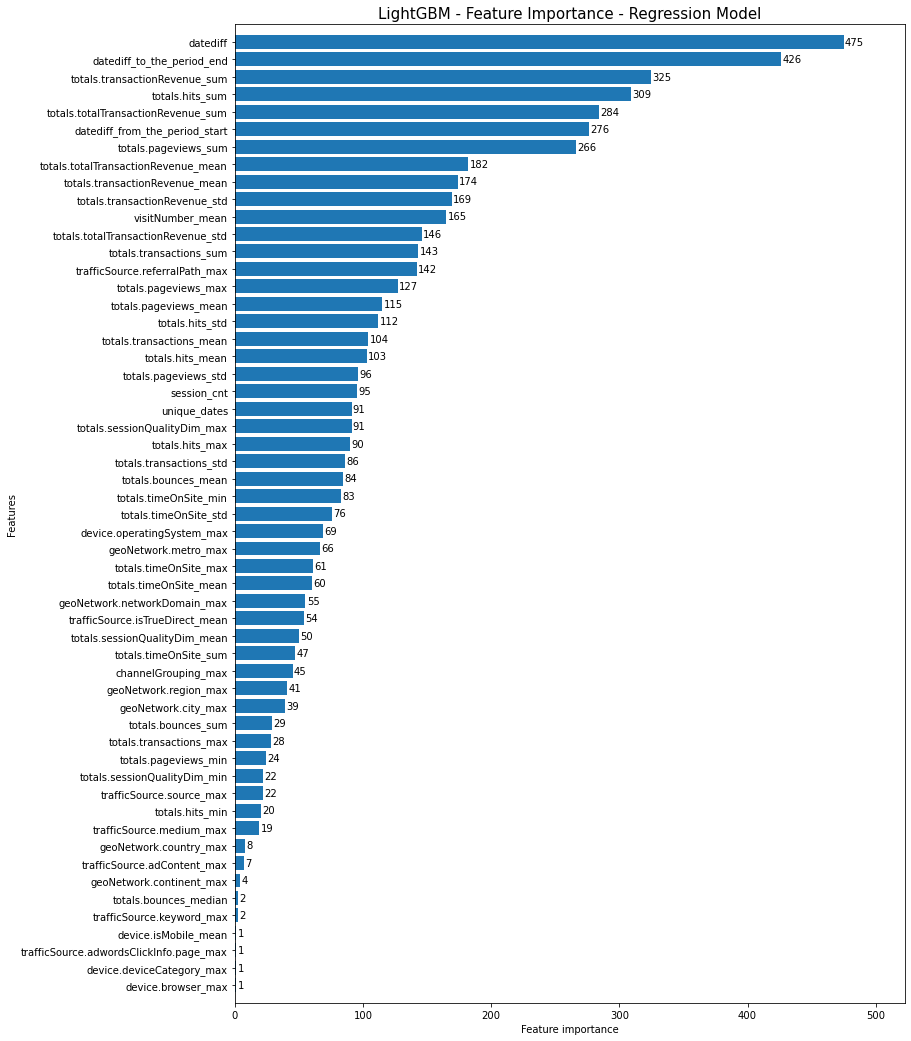

In [ ]:
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(lgb_model_reg, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance - Regression Model", fontsize=15)
plt.show()

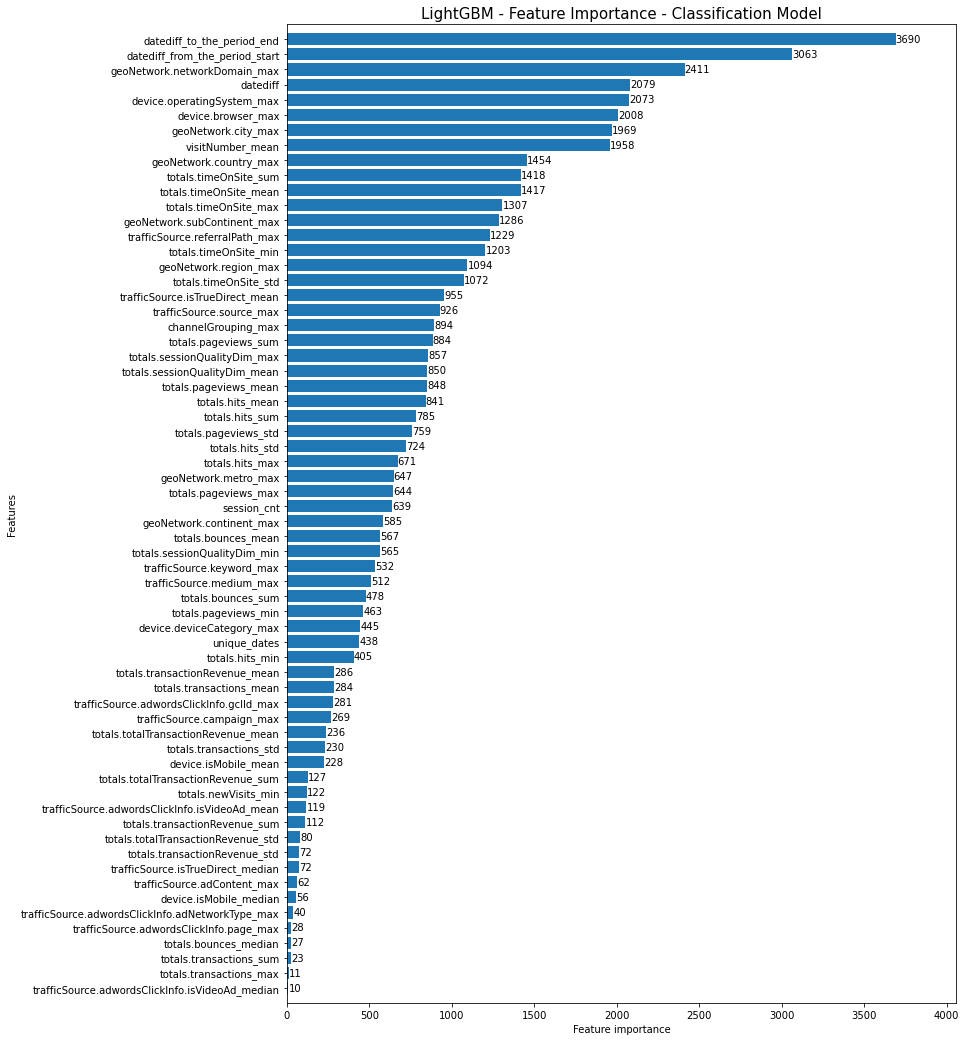

In [ ]:
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(lgb_model_cl, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance - Classification Model", fontsize=15)
plt.show()

<br>Some findings:


1.   Datediff features (datediff, datediff_to_the_period_end, datediff_from_the_period_start) and visitNumber (how many times the visitor has visited the store) are among the most important features for both models.
2.   Hits, pageviews and transactionRevenue are highly predictive of visitors' future revenue.
3.   Geographical features, device features, and timeOnSite are highly predictive of whether visitors would return in the future.
<br><br>

In [ ]:
pred_y_reg = lgb_model_reg.predict(val_X)
pred_y_reg[pred_y_reg < 0] = 0

In [ ]:
pred_y_cl = lgb_model_cl.predict(val_X)

In [ ]:
np.sqrt(mean_squared_error(val_y_reg, np.zeros(val_y.shape[0]))) # baseline prediction rmse (all-zero predictions)

0.30407420097899274

In [ ]:
np.sqrt(mean_squared_error(val_y_reg, pred_y_reg*pred_y_cl))

0.3030299648371036

<br>As is explored, the target variable is highly sparse and all-zero predictions achieved a rmse of 0.304 on validation data. The models achieved a slightly better rmse of 0.303.<br><br>

In [ ]:
# predict on test set

pred_test_reg = lgb_model_reg.predict(test_X)
pred_test_reg[pred_test_reg<0] = 0
pred_test_cl = lgb_model_cl.predict(test_X)
pred_test = pred_test_reg*pred_test_cl

result = pd.DataFrame()
result['fullVisitorId'] = test_id
result['PredictedLogRevenue'] = pred_test
result

,fullVisitorId,PredictedLogRevenue
0,0000018966949534117,0.000124
1,0000039738481224681,0.000032
2,0000073585230191399,0.000022
3,0000087588448856385,0.000019
4,0000149787903119437,0.000020
...,...,...
296525,9999862054614696520,0.000023
296526,9999898168621645223,0.000042
296527,999990167740728398,0.000034
296528,9999915620249883537,0.000027


In [ ]:
result.to_csv('result.csv', index=False)

## <br>**Conclusion:**
In this notebook I've built the LightGBM classification and regression models to predict Google Merchandise Store visitors' future transaction revenue; the final predictions have achieved rmse of 0.8863 graded by kaggle.


1.   I used the kaggle api to extract the datasets, transformed the json columns and read the data into dataframes.
2.   I preprocessed the data by filling missing values, converting datatypes and encoding categorical features.
3.   For feature engineering, I partitioned the training data based on visit dates to fit into the prediction problem, and constructed various new features to capture multiple dimensions of visitors, especially time and session features.
4.   I built and fine-tuned the models through cross-validation. The final predictions of baseline models and best models achieved rmse of 0.8867 and 0.8863, respectively.
5.   Since the best models' rmse only improved slightly compared to baseline models, perhaps model tuning isn't the best option since it would be time-consuming.
6.   Time, session, geography, and device features were among the most important features.<br><br>
